In [49]:
import numpy as np
import pandas as pd
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.layers import LayerNormalization
from tensorflow.keras.optimizers import Adam

from glob import glob

monet_path = ("gan-getting-started/monet_jpg")
photo_path = ("gan-getting-started/photo_jpg")

### Week 5: Monet Painting Generation

#### Problem
This project involves analyzing various paintings by Monet and creating an ML model that can modify photos to have a similar aesthetic as Monet's paintings. This data is sourced from https://www.kaggle.com/competitions/gan-getting-started/overview, containing 300 paintings by Monet, as well as various photos to try and stylize.

#### EDA
First, I'll take a look at the provided Monet images. There are 300 images total, all of them 256x256 images.

Total images:  300
Image sizes:  {(256, 256)}


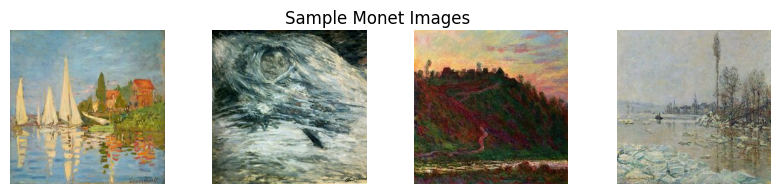

In [50]:
monet_images = glob(monet_path + "/*.jpg")

def image_sample(images, title):
    print("Total images: ", len(images))
    
    plt.figure(figsize=(10, 2))
    
    size_set = set()

    for image in images:
        img = load_img(image)
        size_set.add(img.size)
    
    for i, img_path in enumerate(images[:4]):
        img = load_img(img_path)    
        plt.subplot(1, 4, i + 1)  
        plt.imshow(img) 
        plt.axis('off')  
    
    plt.suptitle(f'Sample {title} Images') 
    
    print("Image sizes: ", size_set)
    
    plt.show()

image_sample(monet_images, "Monet")

I'll take a look at the Photos as well. There's 7038 total, all 256x256 images again, so I won't need to resize any images.

Total images:  7038
Image sizes:  {(256, 256)}


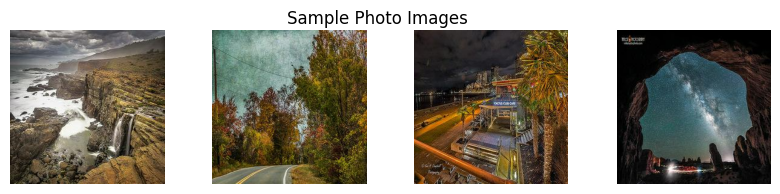

In [51]:
photo_images = glob(photo_path + "/*.jpg")
image_sample(photo_images, "Photo")

Next, I'll preprocess the training images and create the training dataset (Need to normalize/resize the images, then put them into datasets for the models to us).

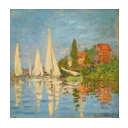

In [52]:
BATCH_SIZE = 1 

def load_image(file_path):
    img = tf.io.read_file(file_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [256, 256])
    img = (img / 127.5) - 1  # Normalize to [-1, 1]
    return img

# Create a TensorFlow dataset
monet_dataset = tf.data.Dataset.from_tensor_slices(monet_images).map(load_image).batch(BATCH_SIZE)
photo_dataset =  tf.data.Dataset.from_tensor_slices(photo_images).map(load_image).batch(BATCH_SIZE)

# Check dataset loaded images
for batch in monet_dataset.take(1):
    # Denormalize images to [0, 1] for visualization
    batch = (batch + 1.0) / 2.0  
    plt.subplot(3, 3, i + 1)
    plt.imshow(batch[i])
    plt.axis('off')
    plt.show()

### Model Architecture

#### Generator Component
Building the generator component for the GAN. The model needs to first downsample the images to get extract important features, then I run some residual blocks to apply the transformations, and finally upsampling back to a new image.

In [80]:
def residual_block(input_layer, filters):
    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(input_layer)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(filters, kernel_size=3, strides=1, padding='same')(x)
    x = layers.BatchNormalization()(x)

    return layers.Add()([x, input_layer])  # Skip connection

def build_gen():
    inputs = layers.Input(shape=(256, 256, 3))
    
    # Downsampling layers
    x = layers.Conv2D(64, kernel_size=7, strides=1, padding='same')(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2D(256, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Residual blocks
    for _ in range(6):  # Number of residual blocks
        x = residual_block(x, 256)

    # Upsampling layers
    x = layers.Conv2DTranspose(128, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    x = layers.Conv2DTranspose(64, kernel_size=3, strides=2, padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)

    # Final layer
    outputs = layers.Conv2D(3, kernel_size=7, strides=1, padding='same', activation='tanh')(x)

    return tf.keras.Model(inputs, outputs)

monet_generator = build_gen()
photo_generator = build_gen()
monet_generator.summary()

Model: "functional_18"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_18      │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_156 (Conv2D) │ (None, 256, 256,  │      9,472 │ input_layer_18[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_156[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_66 (ReLU)     │ (None, 256, 256,  │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_157 (Conv2D) │ (None, 128, 128,  │     73,856 │ re_lu_66[0][0]    │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_157[0][0]  │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_67 (ReLU)     │ (None, 128, 128,  │          0 │ batch_normalizat… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_158 (Conv2D) │ (None, 64, 64,    │    295,168 │ re_lu_67[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_158[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_68 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_159 (Conv2D) │ (None, 64, 64,    │    590,080 │ re_lu_68[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_159[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_69 (ReLU)     │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_160 (Conv2D) │ (None, 64, 64,    │    590,080 │ re_lu_69[0][0]    │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_160[0][0]  │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_36 (Add)        │ (None, 64, 64,    │          0 │ batch_normalizat… │
│                     │ 256)              │            │ re_lu_68[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_161 (Conv2D) │ (None, 64, 64,    │    590,080 │ add_36[0][0]    

 Total params: 7,852,547 (29.96 MB)

 Trainable params: 7,845,123 (29.93 MB)

 Non-trainable params: 7,424 (29.00 KB)

#### Discriminator
The discriminator needs to take in a 256x256x3 image, and determine if it's real or fake. Basing off the PatchGAN architecture, which unlike a basic CNN which would classify an entire image as real or fake, classifies patches of the image. I use PatchGAN since it has a heavier emphasis on local features and details, which I think makes sense for detailed/stylized paintings which we're trying to emulate.

Using InstanceNormalization instead of BatchNormalization since it's less likely to end up with dead gradient with small batch sizes (in this case, batch size is just 1). Probably not necessary, but was added while trying to debug an issue where I was getting invalid gradients.

In [81]:
class InstanceNormalization(layers.Layer):
    def __init__(self, epsilon=1e-5):
        super(InstanceNormalization, self).__init__()
        self.epsilon = epsilon

    def build(self, input_shape):
        self.gamma = self.add_weight(shape=(1,), initializer='ones', trainable=True)
        self.beta = self.add_weight(shape=(1,), initializer='zeros', trainable=True)

    def call(self, inputs):
        mean, variance = tf.nn.moments(inputs, axes=[1, 2], keepdims=True)
        normalized = (inputs - mean) / tf.sqrt(variance + self.epsilon)
        return self.gamma * normalized + self.beta

def build_discriminator():
    inputs = layers.Input(shape=(256, 256, 3))  # Input image

    # Convolutional layer 1: No normalization in the first layer
    x = layers.Conv2D(64, kernel_size=4, strides=2, padding='same')(inputs)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Convolutional layer 2
    x = layers.Conv2D(128, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Convolutional layer 3
    x = layers.Conv2D(256, kernel_size=4, strides=2, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Convolutional layer 4
    x = layers.Conv2D(512, kernel_size=4, strides=1, padding='same')(x)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU(negative_slope=0.2)(x)

    # Final convolutional layer: Outputs a single channel (real/fake classification for patches)
    outputs = layers.Conv2D(1, kernel_size=4, strides=1, padding='same')(x)

    return tf.keras.Model(inputs, outputs)


monet_discriminator = build_discriminator()
photo_discriminator = build_discriminator()
monet_discriminator.summary()

Model: "functional_20"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_20 (InputLayer)     │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_188 (Conv2D)             │ (None, 128, 128, 64)   │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_48 (LeakyReLU)      │ (None, 128, 128, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_189 (Conv2D)             │ (None, 64, 64, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_12       │ (None, 64, 64, 128)    │             2 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_49 (LeakyReLU)      │ (None, 64, 64, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_190 (Conv2D)             │ (None, 32, 32, 256)    │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_13       │ (None, 32, 32, 256)    │             2 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_50 (LeakyReLU)      │ (None, 32, 32, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_191 (Conv2D)             │ (None, 32, 32, 512)    │     2,097,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ instance_normalization_14       │ (None, 32, 32, 512)    │             2 │
│ (InstanceNormalization)         │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_51 (LeakyReLU)      │ (None, 32, 32, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_192 (Conv2D)             │ (None, 32, 32, 1)      │         8,193 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,764,743 (10.55 MB)

 Trainable params: 2,764,743 (10.55 MB)

 Non-trainable params: 0 (0.00 B)

Initializing the optimizers (using Adam, with 0.0001 learning rate), and setting up the loss functions for the generator and discriminator. Both are going to use Binary Cross Entropy for the loss function (since it should return 0/1).

In [83]:
# Model Compilation

loss_object = tf.keras.losses.BinaryCrossentropy(from_logits=True)

generator_optimizer = Adam(learning_rate=0.00001)
discriminator_optimizer = Adam(learning_rate=0.00001)

def discriminator_loss(real, generated):
    real_loss = loss_object(tf.ones_like(real), real)
    generated_loss = loss_object(tf.zeros_like(generated), generated)
    return real_loss + generated_loss

def generator_loss(generated):
    return loss_object(tf.ones_like(generated), generated)

def cycle_consistency_loss(real_image, cycled_image):
    return tf.reduce_mean(tf.abs(real_image - cycled_image))


#### Training Loop
Defining the training loop for the GAN (Generating real and fake images for both the photo and Monet paintings, calculating the loss between the real/fake images, and passing to the discriminator to train). GradientTape is used to record operations performed on the Tensors so they can be used to calculate the gradients for back propagation.

In [92]:
@tf.function
def train_step(real_monet, real_photo):
    with tf.GradientTape(persistent=True) as tape:
        # Monet to Photo to Monet
        fake_photo = monet_generator(real_monet, training=True)
        cycled_monet = photo_generator(fake_photo, training=True)

        # Photo to Monet to Photo
        fake_monet = photo_generator(real_photo, training=True)
        cycled_photo = monet_generator(fake_monet, training=True)

        # Discriminator predictions
        disc_real_monet = monet_discriminator(real_monet, training=True)
        disc_fake_monet = monet_discriminator(fake_monet, training=True)

        disc_real_photo = photo_discriminator(real_photo, training=True)
        disc_fake_photo = photo_discriminator(fake_photo, training=True)

        
        # Losses
        gen_monet_loss = generator_loss(disc_fake_monet)
        gen_photo_loss = generator_loss(disc_fake_photo)

        total_cycle_loss = cycle_consistency_loss(real_monet, cycled_monet) + \
                           cycle_consistency_loss(real_photo, cycled_photo)

        total_gen_loss = gen_monet_loss + gen_photo_loss + total_cycle_loss

        monet_disc_loss = discriminator_loss(disc_real_monet, disc_fake_monet)
        photo_disc_loss = discriminator_loss(disc_real_photo, disc_fake_photo)
        # Backpropagation
        gen_gradients = tape.gradient(total_gen_loss, 
                                  monet_generator.trainable_variables + 
                                  photo_generator.trainable_variables)
        disc_gradients = tape.gradient(monet_disc_loss + photo_disc_loss,
                                   monet_discriminator.trainable_variables + 
                                   photo_discriminator.trainable_variables)
    
    generator_optimizer.apply_gradients(zip(gen_gradients, 
                                      monet_generator.trainable_variables + 
                                      photo_generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(disc_gradients, 
                                       monet_discriminator.trainable_variables + 
                                       photo_discriminator.trainable_variables))


#### Running the Training Loop
Ran for 10 epochs on my own local computer, which took quite a while. Tested other epoch counts on the Kaggle notebook I had to set up for submission (1, 15, 20).

In [85]:
EPOCHS = 10
for epoch in range(EPOCHS):
    print(f'Epoch {epoch + 1}: ')
    for monet, photo in tf.data.Dataset.zip((monet_dataset, photo_dataset)):
        train_step(monet, photo)


Epoch 1: 


2024-12-07 00:24:30.285825: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 2: 
Epoch 3: 
Epoch 4: 
Epoch 5: 
Epoch 6: 
Epoch 7: 
Epoch 8: 
Epoch 9: 


2024-12-07 04:39:33.705057: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


Epoch 10: 


#### Example Outputs

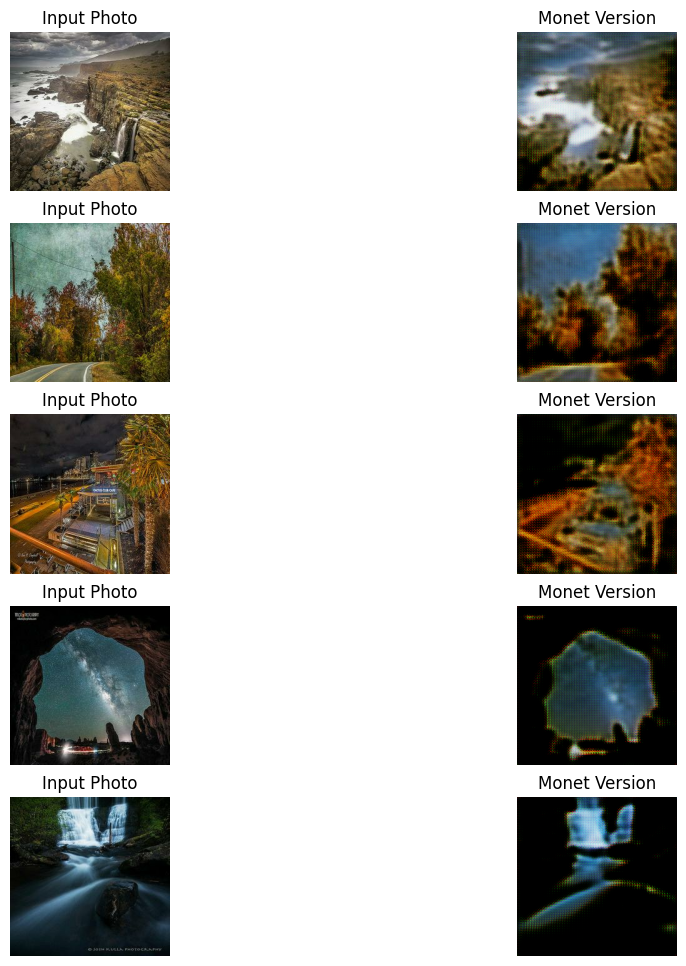

In [87]:
_, ax = plt.subplots(5, 2, figsize=(12, 12))
for i, img in enumerate(photo_dataset.take(5)):
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    img = (img[0] * 127.5 + 127.5).numpy().astype(np.uint8)

    ax[i, 0].imshow(img)
    ax[i, 1].imshow(prediction)
    ax[i, 0].set_title("Input Photo")
    ax[i, 1].set_title("Monet Version")
    ax[i, 0].axis("off")
    ax[i, 1].axis("off")
plt.show()

### Submission
Code I used to submit in the Kaggle version of the notebook.

In [91]:
import PIL
! mkdir ../images

i = 1
for img in photo_dataset:
    prediction = monet_generator(img, training=False)[0].numpy()
    prediction = (prediction * 127.5 + 127.5).astype(np.uint8)
    im = PIL.Image.fromarray(prediction)
    im.save("../images/" + str(i) + ".jpg")
    i += 1


In [ ]:
import shutil
shutil.make_archive("/kaggle/working/images", 'zip', "/kaggle/images")

### Conclusion
Since the Kaggle submission process requires me to make a separate notebook on their platform, some of the work I did isn't included in this notebook. For the most part, this involved just trying out different epoch counts and some small adjustments/optimizations to better utilize the GPU.

The runs took much longer than I expected, so I didn't get a chance to do too much hyperparameter tuning. In this submission notebook, I only ran 10 epochs as an example, but I did run more (1, 15, and 20) on the Kaggle dataset, since their GPU is much better than my personal laptop's. If I had time for more iterations, the hyperparameters I'd likely tune are the learning rates and the epoch count. 

Unfortunately, I don't have enough data points to determine what epoch count the model starts to overfit. My final score was 114.14041 though, which isn't great (but at least shows it's doing something). Looking at the samples I have with 10 epochs, the Monet versions kinda just look like blurry photos, so I imagine it's still pretty far from overfitting.